In [1]:
from support.common.connect.connect_db.ConnectDB import localhost_query
from support.common.connect.connect_db.ConnectDB import DBinfo
import pymysql
import pandas as pd 
import numpy
import re
import matplotlib.pyplot as plt #绘图
from matplotlib.font_manager import FontProperties
import matplotlib as mpl #配置字体
import seaborn as sns
from pyecharts import Bar,Line,Pie,Style,Scatter,Boxplot
'''
companysize_education_sql = "select jobs_lagou_position_positionType as 'positionType',jobs_lagou_position_companySize as 'companySize',jobs_lagou_position_education as 'education',count(1) as 'count' from jobs_lagou_info inner join jobs_lagou_position on jobs_lagou_position_positionId = jobs_lagou_info_positionId and jobs_lagou_position_positionName  not regexp '开发|性能|实习|主管|总监|经理|组长|挖掘|算法|DBA|负责|架构' group by jobs_lagou_position_positionType,jobs_lagou_position_companySize,jobs_lagou_position_education;"
DBdict = DBinfo.DBDict
companysize_education_datas = pd.read_sql(companysize_education_sql,con=pymysql.connect(**DBdict['local']))
'''
DBdict = DBinfo.DBDict
all_info_sql = "select * from jobs_lagou_info inner join jobs_lagou_position on jobs_lagou_position_positionId = jobs_lagou_info_positionId and jobs_lagou_position_positionName  not regexp '开发|性能|实习|主管|总监|经理|组长|挖掘|算法|DBA|负责|架构';"
all_info = pd.read_sql(all_info_sql,con=pymysql.connect(**DBdict['local'])) 


ERROR:lml.utils:failed to import pyecharts_snapshot
Traceback (most recent call last):
  File "/Users/wangyuxiang/PycharmProjects/support/venv/lib/python3.6/site-packages/lml/utils.py", line 43, in do_import
    plugin_module = __import__(plugin_module_name)
ModuleNotFoundError: No module named 'pyecharts_snapshot'


In [62]:
# 城市与招聘职位数
city_pos_Test = pd.DataFrame({'city':['北京','上海','广州','深圳'],'count':[9401,2839,669,1614]})
city_pos_Data = pd.DataFrame({'city':['北京','上海','广州','深圳'],'count':[7209,941,220,299]})

city_pos_pie = Pie("城市与招聘职位数-数据分析", "左图：测试\n右图：数据分析",title_pos='center')
style = Style()
pie_style = style.add(is_label_show=True,label_text_color=None)
city_pos_pie.add("测试",city_pos_Test['city'],city_pos_Test['count'],center=[30, 60], radius=[0,55],legend_orient="vertical",legend_pos="left",**pie_style)
city_pos_pie.add("数据分析",city_pos_Data['city'],city_pos_Data['count'], center=[70, 60], radius=[0,55],legend_orient="vertical",legend_pos="left",**pie_style)
city_pos_pie

In [63]:
# 公司规模和学历二维分析
comp_edu = all_info[['jobs_lagou_position_positionType','jobs_lagou_position_companySize','jobs_lagou_position_education']]

# group by 职位类别、公司规模、学历
comp_edu = comp_edu.groupby(['jobs_lagou_position_positionType','jobs_lagou_position_companySize','jobs_lagou_position_education']).size()
# series to dataframe
comp_edu = comp_edu.reset_index(name='count')
# raname columns
comp_edu.columns = ['positionType','companySize','education','count']

# companySize的dataframe，自生成df，如果使用排序的话，比较混乱
companySize = pd.DataFrame({'companySize':['少于15人','15-50人','50-150人','150-500人','500-2000人','2000人以上']})

# 选择岗位类别
positionType = '测试' #'数据分析'
comp_edu = comp_edu.loc[(comp_edu['positionType']==positionType)]

# 制图
comp_edu_line = Line("公司规模与学历-{0}".format(positionType))
for i in ['本科','大专','不限']:
    # 合并并填充0值（因为echart多折线图只会显示每条折线共有的x坐标，如果某条线的x坐标确实，则其他的折线也会剔除数据，故作特殊处理
    comp_edu_data = pd.merge(companySize,comp_edu.loc[(comp_edu['education']==i)],on=["companySize"],how='outer').fillna(value=0)
    comp_edu_line.add(i, x_axis=comp_edu_data["companySize"], y_axis=comp_edu_data["count"],mark_line=["average"])
comp_edu_line

In [64]:

# 经验和薪资水平二维分析
info_from_excel = pd.read_excel("/Users/wangyuxiang/Desktop/lagoudata.xlsx",header=0)
years_sala = info_from_excel[['jobs_lagou_position_positionType','average','jobs_lagou_position_workYear']]
years_sala.columns = ['positionType','average','workYear']

def assort_salary(str_01):
    reg_str01 = "(\d+)"
    res_01 = re.findall(reg_str01, str_01)
    if len(res_01) == 2:
        a0 = int(res_01[0])
        b0 = int(res_01[1])
    else :
        a0 = int(res_01[0])
        b0 = int(res_01[0])
    return (a0+b0)/2

test_datas = years_sala.loc[years_sala['positionType']=='测试']
analy_datas = years_sala.loc[years_sala['positionType']=='数据分析']


Years = ['应届毕业生','不限','1年以下','1-3年','3-5年','5-10年']

y_test = []
y_analy = []
for j in Years:
    analy_data = analy_datas.loc[analy_datas['workYear']==j]
    test_data = test_datas.loc[test_datas['workYear']==j]
    if analy_data.empty == 1 :
        y_analy.append(pd.Series([0,0,0]))
        y_test.append(test_data['average'])
    elif test_datas.empty == 1 :
        y_test.append(pd.Series([0,0,0]))
        y_analy.append(analy_data['average'])
    else:
        y_test.append(test_data['average'])
        y_analy.append(analy_data['average'])

        
# 箱形图实测有两处坑：
# 1、如果某值的df为空，需要特殊处理，填充pd.series，否则图形混乱
# 2、必须保证箱形图的单个y坐标，最低有3个数值[0,0,0]，如果有少于3个，则会被覆盖，图形混乱

boxplot = Boxplot("")
boxplot.add("测试", Years,boxplot.prepare_data(y_test))
boxplot.add("数据分析", Years,boxplot.prepare_data(y_analy))
boxplot

[('经验', 118), ('能力', 55), ('熟练掌握', 32), ('Python', 32), ('熟练 使用', 32), ('沟通 能力', 31), ('数据库', 28), ('统计', 28), ('专业', 24), ('行业', 23)]


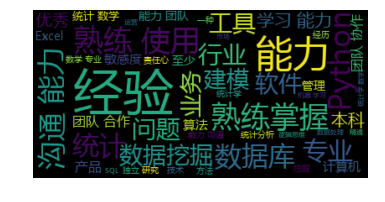

In [116]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from support.common.connect.connect_db.ConnectDB import localhost_query
import jieba

#work_duty = "充分参与整个开发流程，从制定测试计划到产品上线最后一道关卡的把控，在此基础上，配合相关人员，提供针对于产品结构及功能的指导意见主要参与测试app和we应用/对新鲜事物有兴趣且能够踏下心来去做，在有资源有条件的情况下，愿意接触自动化测试/"
#work_requirement = "熟悉黑白盒测试的流程及过程管理，（编写测试用例 bug跟踪 搭建测试环境 编写缺陷等）/实际项目中用过至少二种较为流行的自动化测试工具，如Selenium/熟悉linux，能够编写基本的shell脚本/熟悉基本的网络协议，对udp，tcp协议有基础的理解，对应用层的协议有基本理解/熟悉SQL及常用数据库，如nosql：redis，mongo对批量导入测试数据，或者编写测试数据脚本有过了解/知悉如何使用jmeter（RoadRunner）进行性能方面的测试/年以上web测试经验，年以上app测试经验/熟练掌握Docker，jenkins以及公有云的使用者优先/"

def create_wordcloud(info,stopwords_list):
    wordlist = jieba.cut(info,cut_all=False,HMM=False)  # 采用精确模式
    # 设置停止词
    stopwords = set('')
    stopwords.update(stopwords_list)
    text = " ".join(wordlist)

    wordcloud = WordCloud(
        width=400,
        height=200,
        background_color = "black", # 背景颜色
        max_words = 50, # 最多词个数
        stopwords = stopwords, #设置停用词
        font_path = "/Users/wangyuxiang/Library/Fonts/msyh.ttf", # 中文字体
        max_font_size = 60,  # 字体最大值
        random_state = 30, # 配色方案

    ).generate(text)

    process_word = WordCloud.process_text(wordcloud,text)

    # 获取文本词频最高的前10个词
    sort = sorted(process_word.items(),key=lambda e:e[1],reverse=True)
    print(sort[:10])

    # 存储和展示
    wordcloud.to_file('cloud.jpg')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()


if __name__ == '__main__':
    
    positionType = '数据分析'
    #advantage_sql = "select jobs_lagou_position_positionAdvantage,jobs_lagou_position_companyLabelList from jobs_lagou_position where jobs_lagou_position_positionType = '{0}';".format(positionType)

    wordcloud_info = all_info[['jobs_lagou_position_positionType','jobs_lagou_position_positionAdvantage','jobs_lagou_position_companyLabelList','jobs_lagou_info_work_duty','jobs_lagou_info_work_requirement']]      
    position_wordcloud = wordcloud_info.loc[wordcloud_info['jobs_lagou_position_positionType']==positionType]
    
    wordcloud_type = position_wordcloud['jobs_lagou_info_work_requirement']
    
    
    #all_advantage = localhost_query(advantage_sql)
    
    
    wordtext = ""
    companyLabelList = ""

    for i in wordcloud_type:
        wordtext = "".join([wordtext,i])

    text_stopwords = ['测试','进行','参与','工作','根据','完成','熟悉','优先','以上学历','具备','常用','掌握','系统'
                      '了解','以上','一定','能够','基本','良好','相关','福利','数据','分析','数据分析','通过','提供','公司','了解',
                     "熟练使用",'具有']

    # 去掉空格

    create_wordcloud(wordtext,text_stopwords)